In [62]:
import pandas as pd
import numpy as np
import warnings
from xgboost import XGBRegressor
from utils import utils_gn, utils_sevsn, utils_noah, utils_models
import importlib
importlib.reload(utils_gn)
importlib.reload(utils_sevsn)
importlib.reload(utils_noah)
importlib.reload(utils_models)
warnings.filterwarnings('ignore')

In [63]:
# read the data
df_raw = (utils_gn.read_data('severson_all.pkl')).drop('cycle_life', axis=1).join(utils_gn.read_data('noah_all.pkl'))
df = df_raw.copy()
df.head()

,mean_Q_100_10,log_mean_Q_100_10,var_Q_100_10,log_var_Q_100_10,min_Q_100_10,log_min_Q_100_10,skew_Q_100_10,log_skew_Q_100_10,kurt_Q_100_10,log_kurt_Q_100_10,...,dVdQpeak_maxmag_di_y_100m0,dVdQpeak_maxmag_di_y_diff,dVdQpeak_maxarea_di_y_0,dVdQpeak_maxarea_di_y_50,dVdQpeak_maxarea_di_y_100,dVdQpeak_maxarea_di_y_100m0,dVdQpeak_maxarea_di_y_diff,dSOHdCycCyc1,dSOHdCycCyc100,cycle_life
b1c0,-0.002873,-2.541602,0.000010,-5.014861,-0.008460,-2.072648,-0.532058,-0.274041,1.651688,0.217928,...,-0.005402,0.003024,-79.299389,-75.009448,-67.092799,12.206590,3.626709,0.000388,-0.000031,1851.0
b1c1,-0.004100,-2.387257,0.000010,-5.013960,-0.011004,-1.958457,-0.429375,-0.367163,1.970884,0.294661,...,0.001894,0.000708,-75.511329,-73.411862,-63.284437,12.226892,8.027959,0.000396,-0.000019,2159.0
b1c2,-0.004487,-2.348070,0.000018,-4.737000,-0.017216,-1.764058,-1.080194,0.033502,3.348637,0.524868,...,-0.003083,0.006358,-76.601709,-73.345940,-65.473419,11.128290,4.616753,0.000312,-0.000013,2236.0
b1c3,-0.007456,-2.127507,0.000036,-4.442613,-0.018961,-1.722149,-0.439050,-0.357486,1.904584,0.279800,...,-0.000753,0.013632,-80.446334,-67.731448,-54.750980,25.695354,0.265582,0.000353,-0.000013,1433.0
b1c4,-0.005750,-2.240332,0.000023,-4.647744,-0.013958,-1.855177,-0.362548,-0.440634,1.666169,0.221719,...,0.002110,0.000972,-75.575598,-65.232594,-55.380306,20.195292,-0.490716,0.000347,-0.000030,1708.0


In [64]:
df.index

Index(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9',
       'b1c11',
       ...
       'b3c33', 'b3c34', 'b3c35', 'b3c36', 'b3c40', 'b3c41', 'b3c42', 'b3c43',
       'b3c44', 'b3c45'],
      dtype='object', length=124)

In [65]:
df.columns

Index(['mean_Q_100_10', 'log_mean_Q_100_10', 'var_Q_100_10',
       'log_var_Q_100_10', 'min_Q_100_10', 'log_min_Q_100_10', 'skew_Q_100_10',
       'log_skew_Q_100_10', 'kurt_Q_100_10', 'log_kurt_Q_100_10',
       ...
       'dVdQpeak_maxmag_di_y_100m0', 'dVdQpeak_maxmag_di_y_diff',
       'dVdQpeak_maxarea_di_y_0', 'dVdQpeak_maxarea_di_y_50',
       'dVdQpeak_maxarea_di_y_100', 'dVdQpeak_maxarea_di_y_100m0',
       'dVdQpeak_maxarea_di_y_diff', 'dSOHdCycCyc1', 'dSOHdCycCyc100',
       'cycle_life'],
      dtype='object', length=245)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, b1c0 to b3c45
Columns: 245 entries, mean_Q_100_10 to cycle_life
dtypes: float64(245)
memory usage: 242.4+ KB


In [67]:
df.describe()

,mean_Q_100_10,log_mean_Q_100_10,var_Q_100_10,log_var_Q_100_10,min_Q_100_10,log_min_Q_100_10,skew_Q_100_10,log_skew_Q_100_10,kurt_Q_100_10,log_kurt_Q_100_10,...,dVdQpeak_maxmag_di_y_100m0,dVdQpeak_maxmag_di_y_diff,dVdQpeak_maxarea_di_y_0,dVdQpeak_maxarea_di_y_50,dVdQpeak_maxarea_di_y_100,dVdQpeak_maxarea_di_y_100m0,dVdQpeak_maxarea_di_y_diff,dSOHdCycCyc1,dSOHdCycCyc100,cycle_life
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,-0.018901,-1.795793,0.000223,-3.835354,-0.040760,-1.440500,-0.103301,-0.777828,1.857125,0.261912,...,-0.001076,0.006009,-86.421878,-61.174991,-46.732521,40.020633,-11.299493,0.000265,-0.000069,807.241935
std,0.011347,0.270904,0.000262,0.411134,0.020373,0.217995,0.330102,0.425974,0.454478,0.067593,...,0.046340,0.046048,11.467643,12.863652,6.009183,10.017040,20.110534,0.000136,0.000137,364.359118
min,-0.077684,-3.105396,0.000010,-5.014861,-0.138026,-2.251053,-1.080194,-2.337813,1.612805,0.207582,...,-0.040512,-0.049829,-112.994264,-88.677648,-69.082990,0.491715,-84.612442,-0.000126,-0.001108,170.000000
25%,-0.024233,-1.950487,0.000077,-4.114970,-0.052091,-1.573442,-0.285918,-0.976312,1.710361,0.233088,...,-0.008373,-0.002406,-92.562247,-71.707141,-48.490348,36.962135,-26.034615,0.000190,-0.000065,525.750000
50%,-0.017671,-1.752752,0.000168,-3.775169,-0.038753,-1.411715,-0.141639,-0.713148,1.761561,0.245898,...,-0.005440,0.000974,-86.660594,-59.687399,-45.281185,41.260141,-6.184834,0.000246,-0.000038,743.000000
75%,-0.011208,-1.615590,0.000298,-3.526121,-0.026703,-1.283235,-0.001193,-0.472983,1.866319,0.270984,...,-0.002228,0.005188,-82.555981,-50.581414,-42.951827,46.879305,4.543194,0.000336,-0.000025,945.500000
max,0.000785,-1.109668,0.001875,-2.726901,-0.005610,-0.860038,1.986572,0.298104,5.920243,0.772340,...,0.491715,0.491715,0.491715,-21.537204,-35.616237,61.973190,23.766408,0.000990,0.000211,2236.000000


In [68]:
# prune cells with more than 1250 cycle life
df = df[df['cycle_life'] <= 1250]
df.index

Index(['b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16',
       'b1c17', 'b1c18',
       ...
       'b3c29', 'b3c30', 'b3c31', 'b3c34', 'b3c35', 'b3c36', 'b3c40', 'b3c41',
       'b3c43', 'b3c44'],
      dtype='object', length=113)

In [69]:
# define paramters to use
test_size= 0.2
params= {"n_estimators": 500,
        "max_depth": 2,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error"}

### XGBoost regression without scaling and feature selection

Tree-based regression has started...
Tree-based regression has ended after 1.75 seconds
------------------
Model metrics:
------------------
{'MAE': 60.07585409413213,
 'MAPE': 0.08724137816647926,
 'MSE': 5934.246194811791,
 'R2 score': 0.8915605875810766,
 'RMSE': 77.03405866765551}


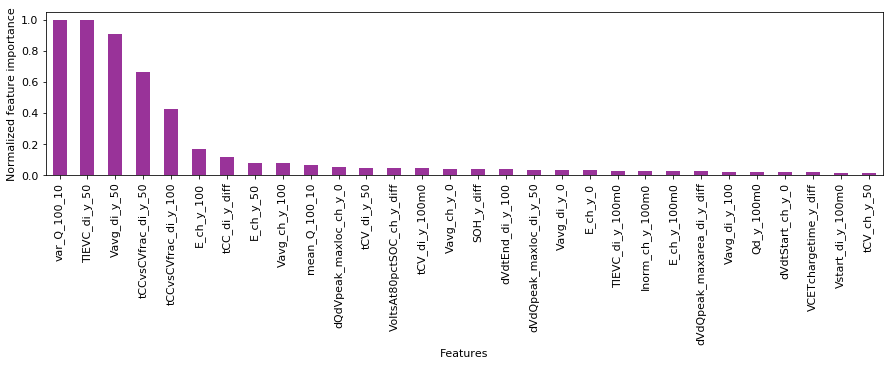

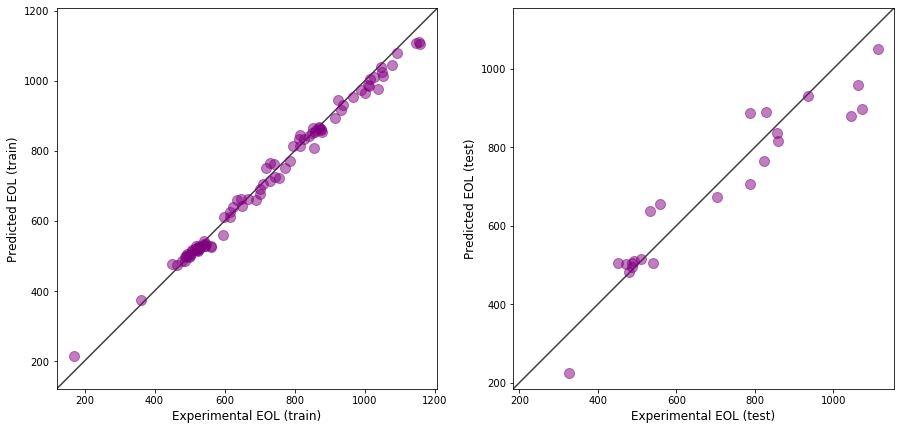

In [70]:
model, metrics = utils_models.fit_tree_based_regression(df=df,
                                                        test_size=test_size,
                                                        feature_selection=False,
                                                        scaling=False,
                                                        params=params,
                                                        plot=True,
                                                        fname='xgb_model')

### XGBoost regression with scaling but without feature selection

Tree-based regression has started...
Tree-based regression has ended after 1.72 seconds
------------------
Model metrics:
------------------
{'MAE': 60.07585409413213,
 'MAPE': 0.08724137816647926,
 'MSE': 5934.246194811791,
 'R2 score': 0.8915605875810766,
 'RMSE': 77.03405866765551}


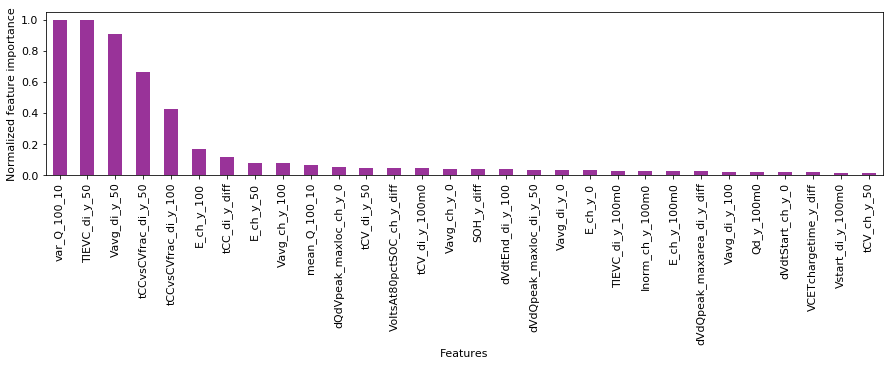

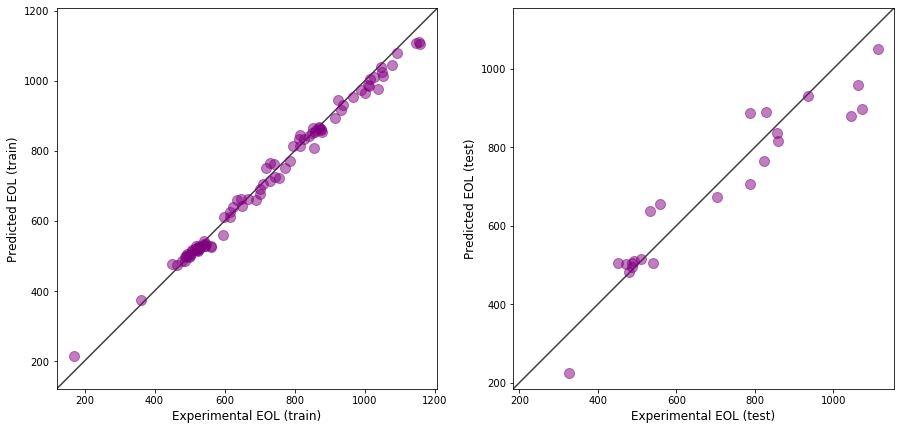

In [71]:
# call XGBoost regression function with scaling and feature selection
model, metrics  = utils_models.fit_tree_based_regression(df=df,
                                                        test_size=test_size,
                                                        feature_selection=False,
                                                        scaling=True,
                                                        params=params,
                                                        plot=True,
                                                        fname='xgb_model_scaled')

### XGBoost regression with feature selection but without scaling with $k=0.5, 0.6, 0.7, 0.8, 0.9$

In [72]:
# define a list of k
k_list = [0.9, 0.8, 0.6, 0.5, 0.4, 0.3, 0.2]

Fitting model with 90 percent of features...
25 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.06 seconds
------------------
Model metrics:
------------------
{'MAE': 60.118367070737094,
 'MAPE': 0.08717128882298712,
 'MSE': 6053.320317556555,
 'R2 score': 0.8893846873098626,
 'RMSE': 77.8030868125202}


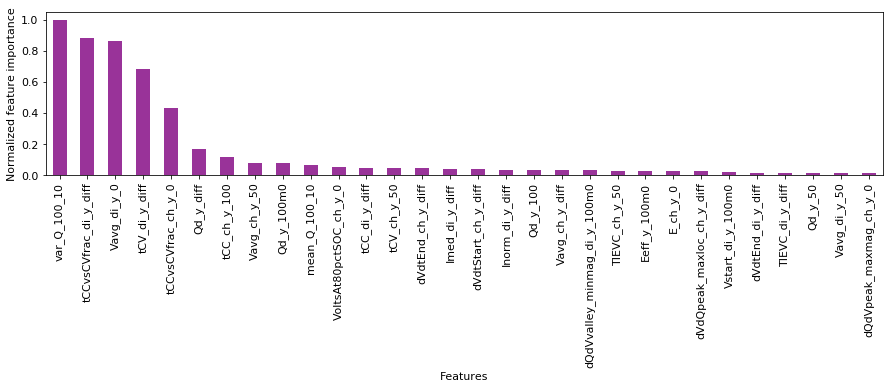

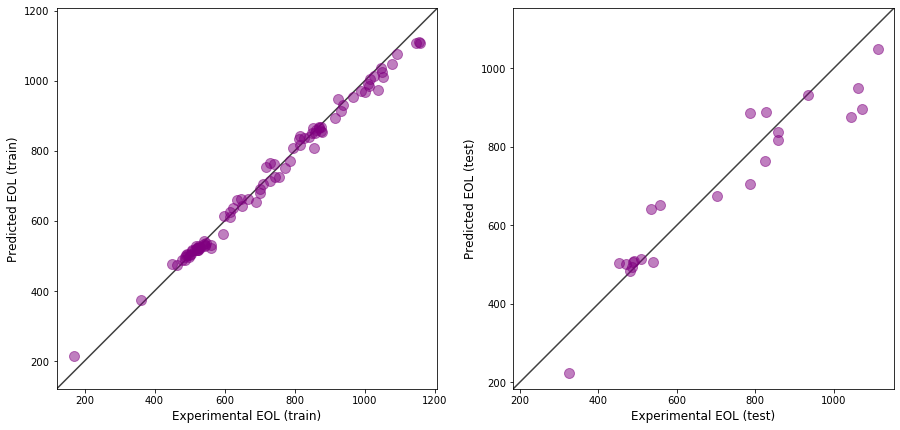

Fitting model with 80 percent of features...
49 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 2.8 seconds
------------------
Model metrics:
------------------
{'MAE': 52.25322822902513,
 'MAPE': 0.0772034643965924,
 'MSE': 4373.088997656358,
 'R2 score': 0.9200883843046296,
 'RMSE': 66.12933537891}


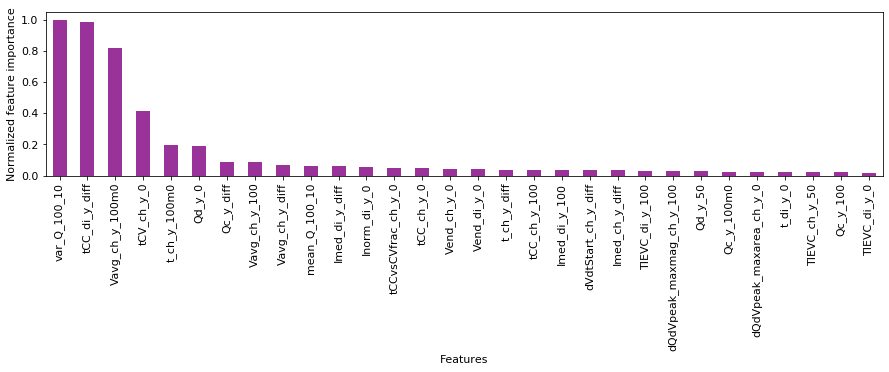

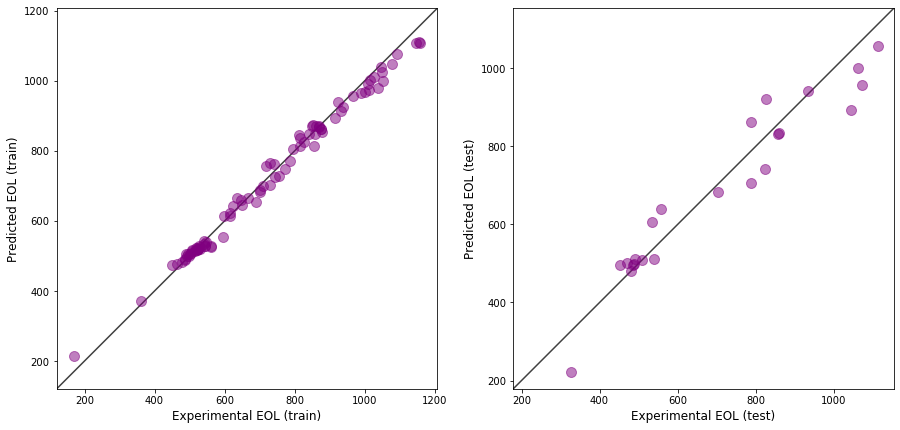

Fitting model with 60 percent of features...
98 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.75 seconds
------------------
Model metrics:
------------------
{'MAE': 49.977631278659985,
 'MAPE': 0.07412315501318854,
 'MSE': 4058.906114700949,
 'R2 score': 0.9258296033409336,
 'RMSE': 63.70954492618001}


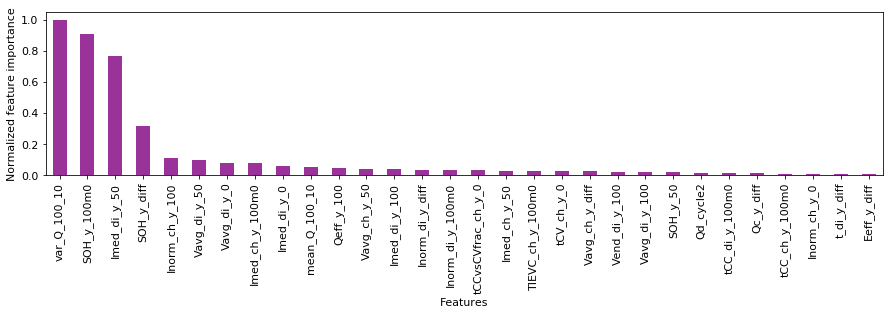

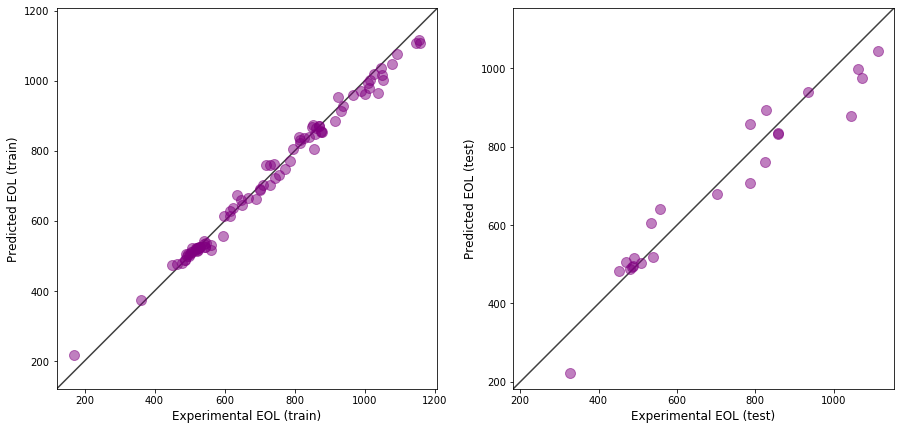

Fitting model with 50 percent of features...
122 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.84 seconds
------------------
Model metrics:
------------------
{'MAE': 49.57373511272928,
 'MAPE': 0.07392780946921709,
 'MSE': 3971.4451866567074,
 'R2 score': 0.927427820087489,
 'RMSE': 63.01940325532056}


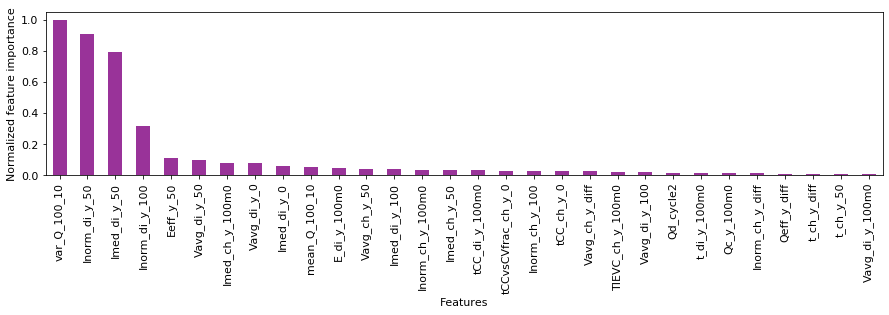

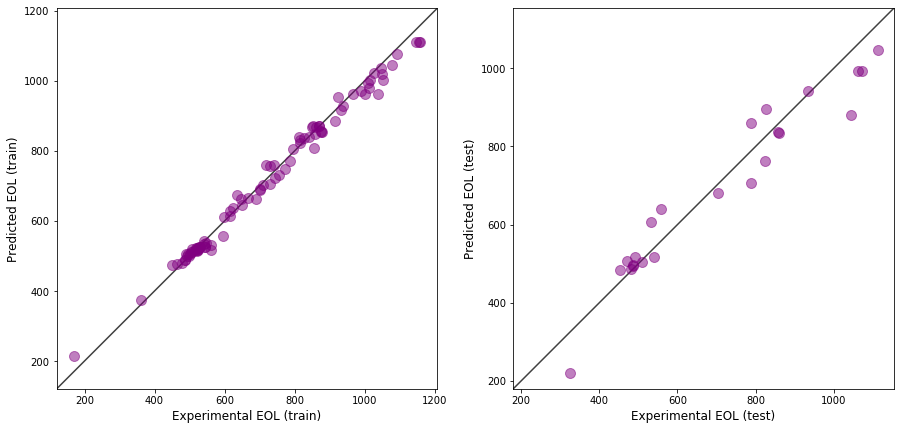

Fitting model with 40 percent of features...
147 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.71 seconds
------------------
Model metrics:
------------------
{'MAE': 51.48247826617697,
 'MAPE': 0.0750344200244935,
 'MSE': 4343.78971835486,
 'R2 score': 0.9206237845100558,
 'RMSE': 65.90743295224644}


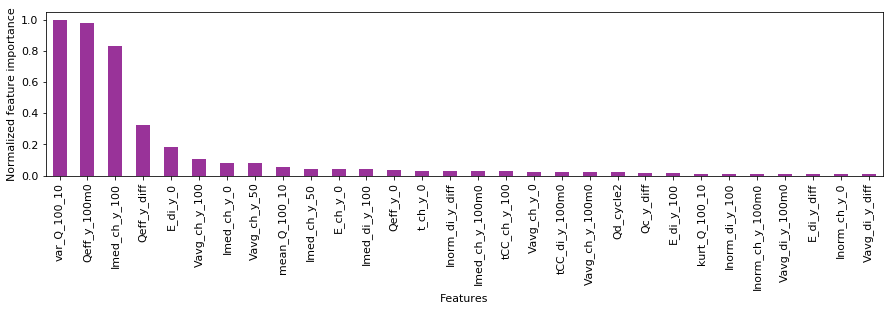

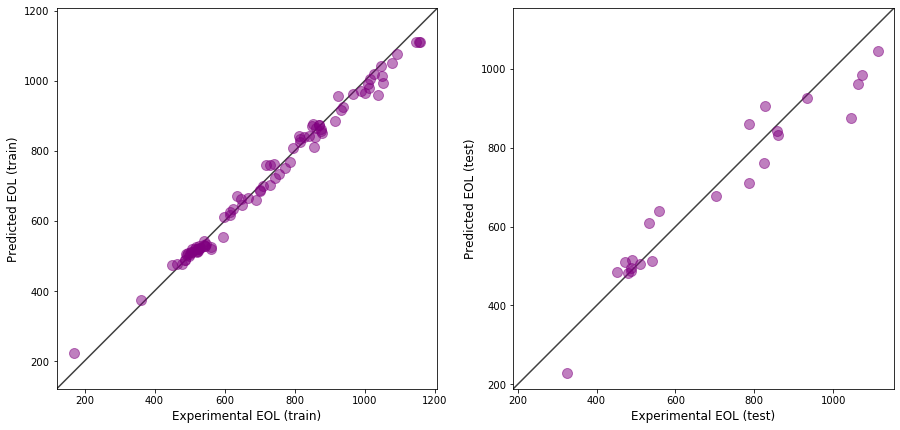

Fitting model with 30 percent of features...
171 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.69 seconds
------------------
Model metrics:
------------------
{'MAE': 48.505679586659305,
 'MAPE': 0.07136454345945407,
 'MSE': 3887.3950045998918,
 'R2 score': 0.9289637105876023,
 'RMSE': 62.34897757461538}


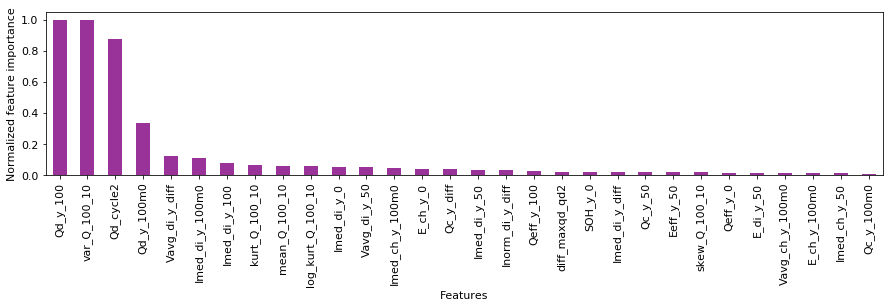

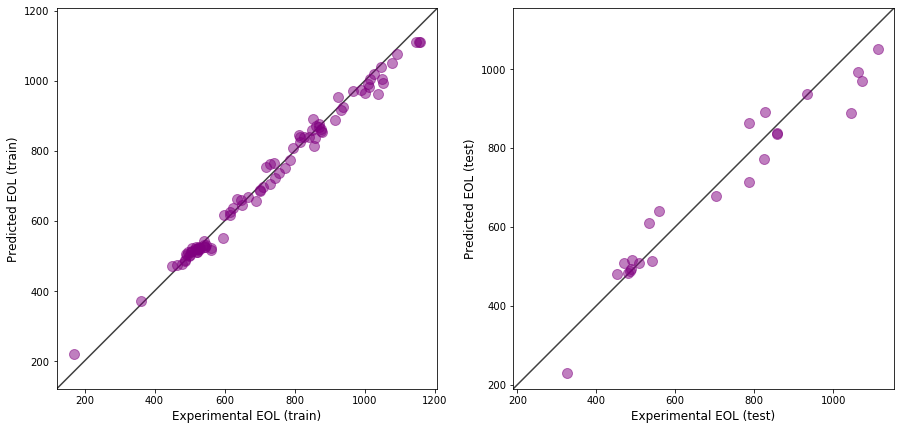

Fitting model with 20 percent of features...
196 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.58 seconds
------------------
Model metrics:
------------------
{'MAE': 46.867661849312164,
 'MAPE': 0.0688508812608895,
 'MSE': 4507.428450747403,
 'R2 score': 0.9176335331104528,
 'RMSE': 67.13738489654928}


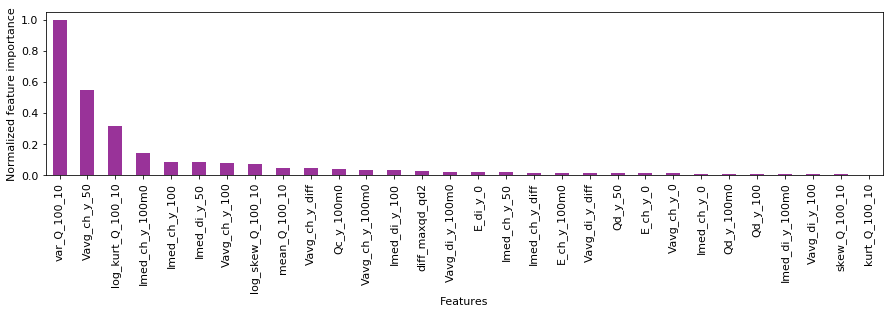

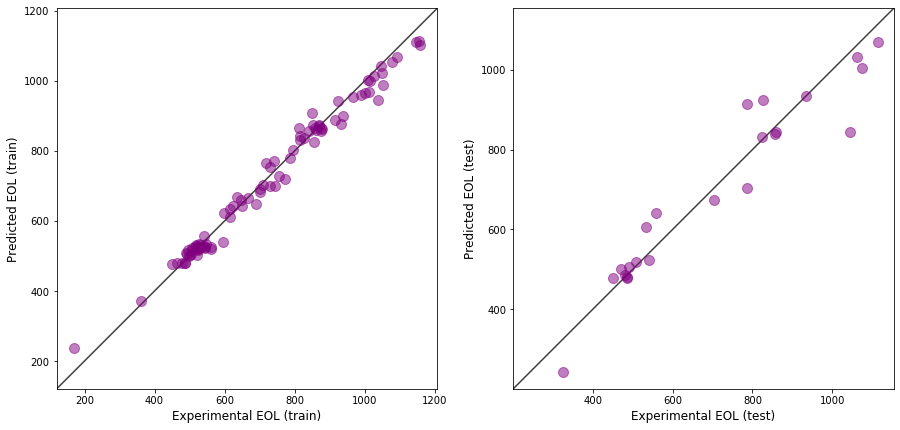

,MAE,MAPE,MSE,RMSE,R2 score
Features used (%),,,,,
90.0,60.118367,0.087171,6053.320318,77.803087,0.889385
80.0,52.253228,0.077203,4373.088998,66.129335,0.920088
60.0,49.977631,0.074123,4058.906115,63.709545,0.925830
50.0,49.573735,0.073928,3971.445187,63.019403,0.927428
40.0,51.482478,0.075034,4343.789718,65.907433,0.920624
30.0,48.505680,0.071365,3887.395005,62.348978,0.928964
20.0,46.867662,0.068851,4507.428451,67.137385,0.917634


In [73]:
# call XGBoost regression function with feature selection using different k
metric_list = []

for k in k_list:
    print('Fitting model with {} percent of features...'.format(int(k*100)))
    model, metrics = utils_models.fit_tree_based_regression(df=df,
                                                            test_size=test_size,
                                                            feature_selection=True,
                                                            scaling=False,
                                                            params=params,
                                                            plot=True,
                                                            fname='xgb_model_ftselection_k_'+str(int(k*100)),
                                                            k=k)
    metric_list.append(list(metrics.values()))

metric_data = pd.DataFrame(data=np.array(metric_list), columns=metrics.keys(), index=np.array(k_list)*100)
metric_data.index.name = 'Features used (%)'
metric_data

### XGBoost regression with feature selection and scaling with $k=0.5, 0.6, 0.7, 0.8, 0.9$

Fitting model with 90 percent of features...
25 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.04 seconds
------------------
Model metrics:
------------------
{'MAE': 60.118367070737094,
 'MAPE': 0.08717128882298712,
 'MSE': 6053.320317556555,
 'R2 score': 0.8893846873098626,
 'RMSE': 77.8030868125202}


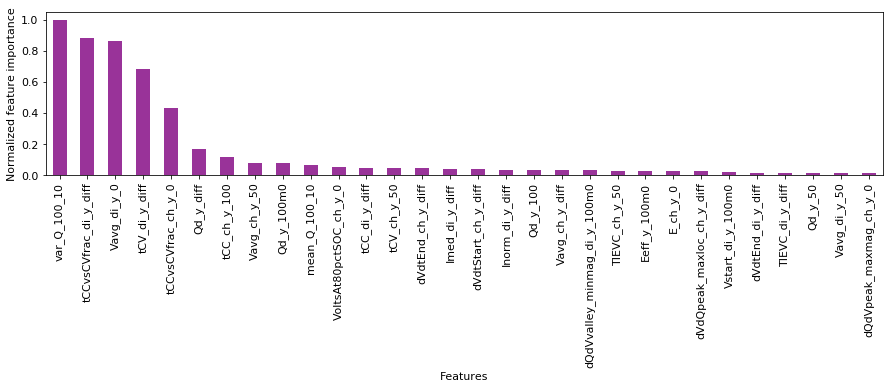

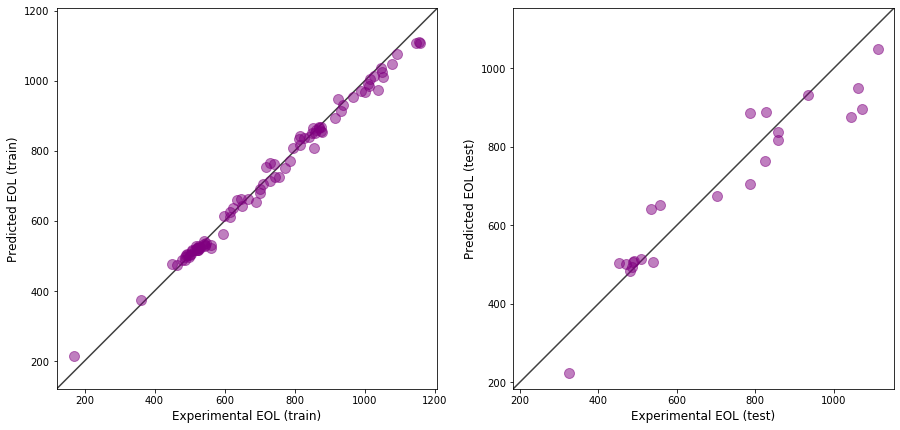

Fitting model with 80 percent of features...
49 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.48 seconds
------------------
Model metrics:
------------------
{'MAE': 52.25322822902513,
 'MAPE': 0.0772034643965924,
 'MSE': 4373.088997656358,
 'R2 score': 0.9200883843046296,
 'RMSE': 66.12933537891}


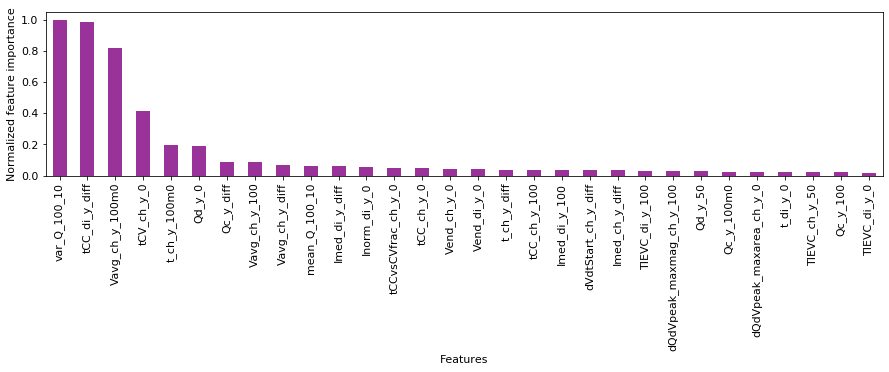

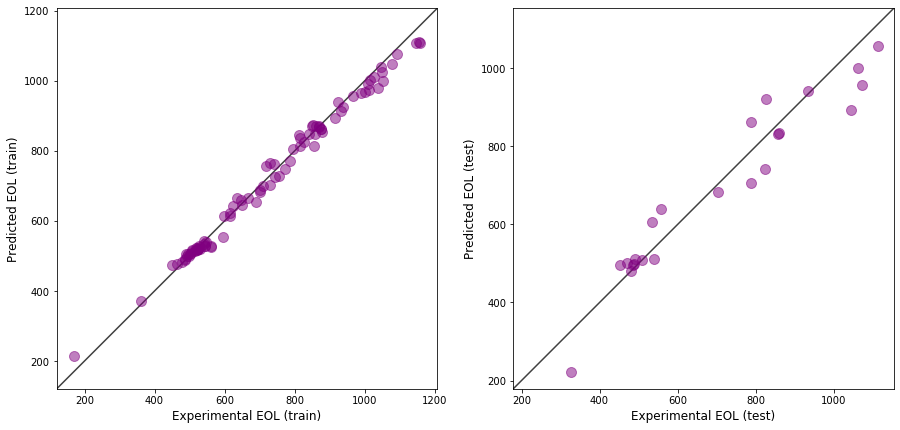

Fitting model with 60 percent of features...
98 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.71 seconds
------------------
Model metrics:
------------------
{'MAE': 49.977631278659985,
 'MAPE': 0.07412315501318854,
 'MSE': 4058.906114700949,
 'R2 score': 0.9258296033409336,
 'RMSE': 63.70954492618001}


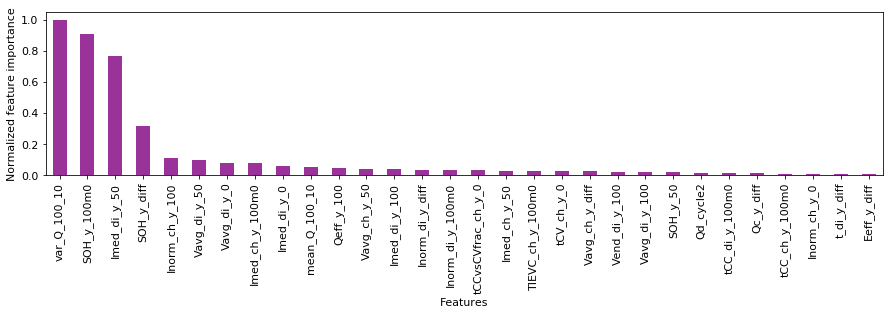

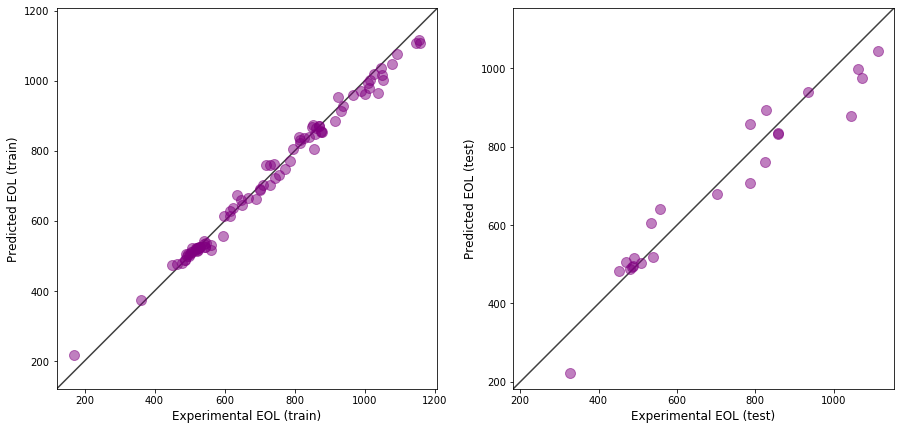

Fitting model with 50 percent of features...
122 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 4.02 seconds
------------------
Model metrics:
------------------
{'MAE': 49.57373511272928,
 'MAPE': 0.07392780946921709,
 'MSE': 3971.4451866567074,
 'R2 score': 0.927427820087489,
 'RMSE': 63.01940325532056}


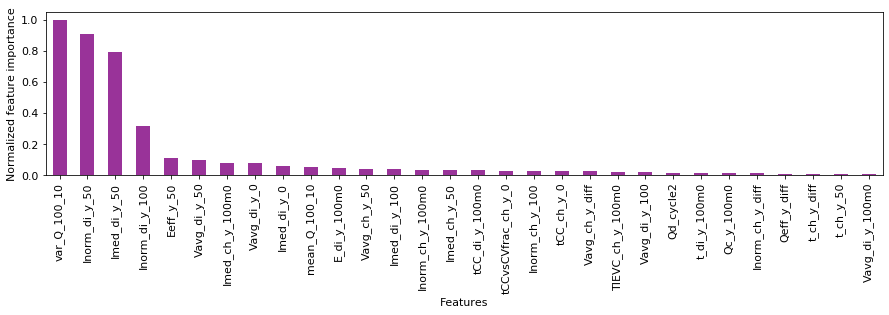

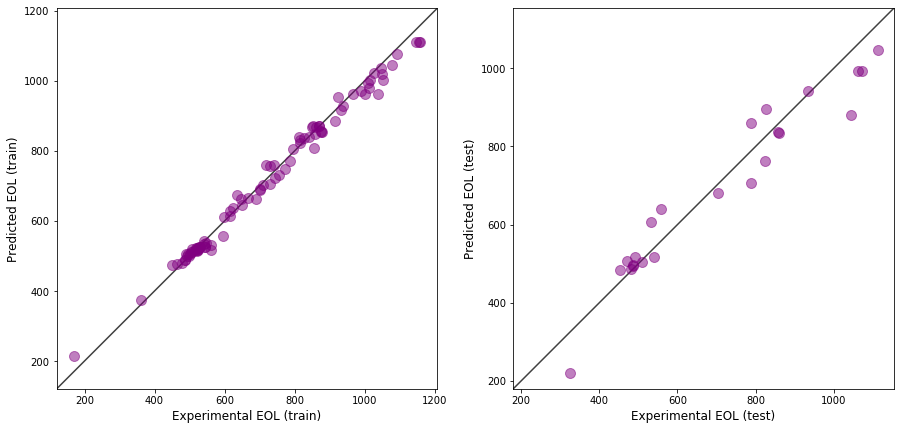

Fitting model with 40 percent of features...
147 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.02 seconds
------------------
Model metrics:
------------------
{'MAE': 51.48247826617697,
 'MAPE': 0.0750344200244935,
 'MSE': 4343.78971835486,
 'R2 score': 0.9206237845100558,
 'RMSE': 65.90743295224644}


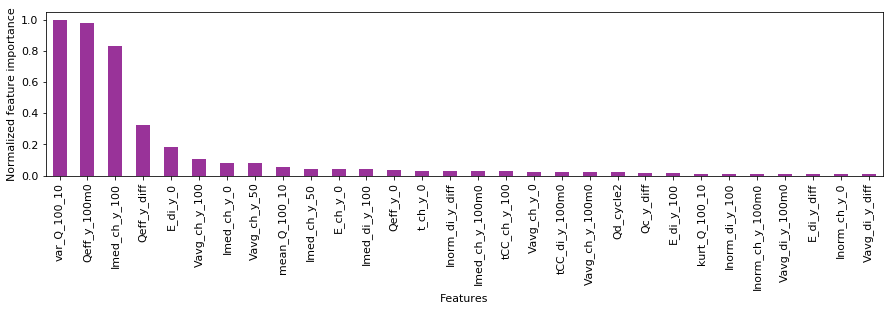

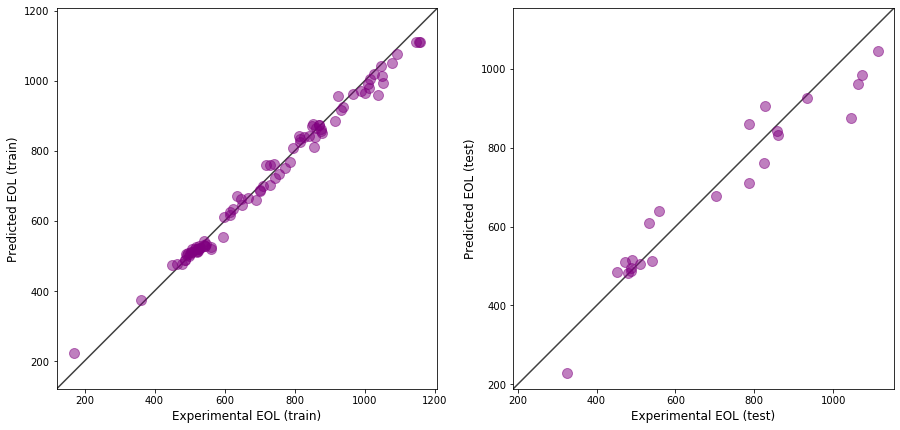

Fitting model with 30 percent of features...
171 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 4.04 seconds
------------------
Model metrics:
------------------
{'MAE': 48.505679586659305,
 'MAPE': 0.07136454345945407,
 'MSE': 3887.3950045998918,
 'R2 score': 0.9289637105876023,
 'RMSE': 62.34897757461538}


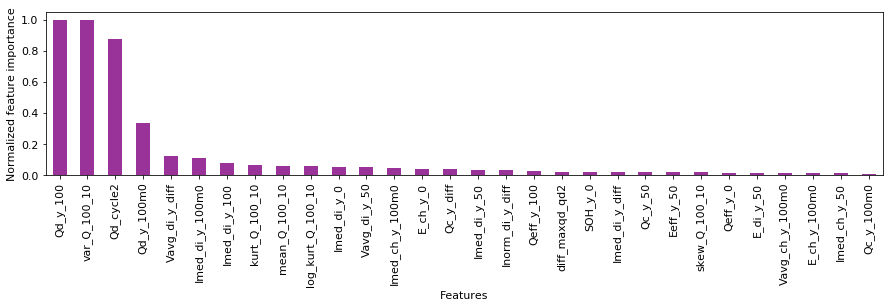

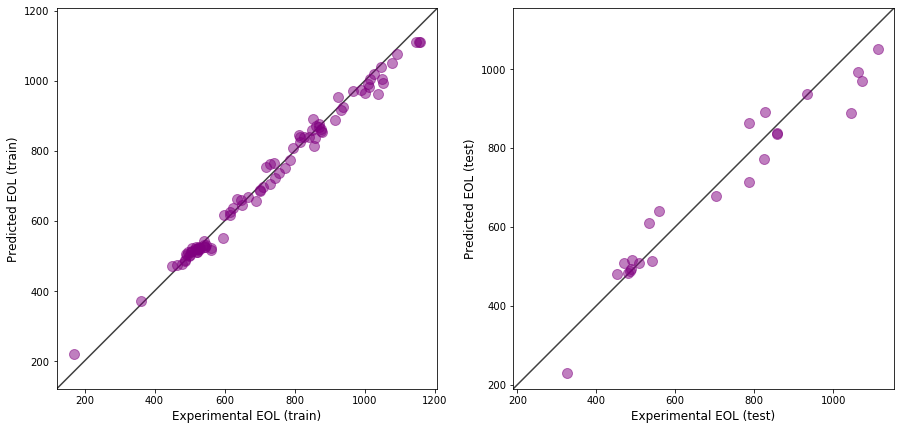

Fitting model with 20 percent of features...
196 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 4.78 seconds
------------------
Model metrics:
------------------
{'MAE': 46.867661849312164,
 'MAPE': 0.0688508812608895,
 'MSE': 4507.428450747403,
 'R2 score': 0.9176335331104528,
 'RMSE': 67.13738489654928}


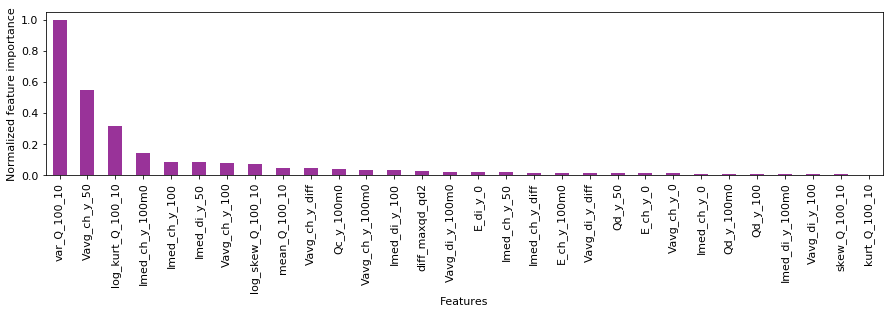

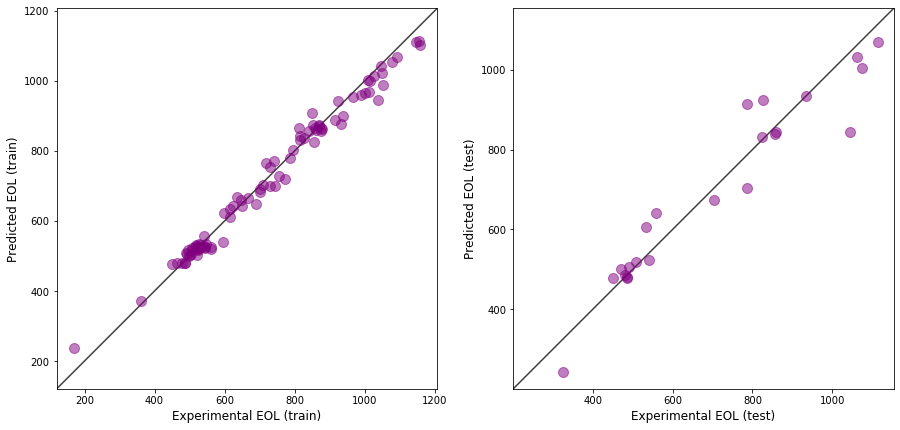

,MAE,MAPE,MSE,RMSE,R2 score
Features used (%),,,,,
90.0,60.118367,0.087171,6053.320318,77.803087,0.889385
80.0,52.253228,0.077203,4373.088998,66.129335,0.920088
60.0,49.977631,0.074123,4058.906115,63.709545,0.925830
50.0,49.573735,0.073928,3971.445187,63.019403,0.927428
40.0,51.482478,0.075034,4343.789718,65.907433,0.920624
30.0,48.505680,0.071365,3887.395005,62.348978,0.928964
20.0,46.867662,0.068851,4507.428451,67.137385,0.917634


In [74]:
# call XGBoost regression function with feature selection and scaling using different k
metric_list = []

for k in k_list:
    print('Fitting model with {} percent of features...'.format(int(k*100)))
    model, metrics = utils_models.fit_tree_based_regression(df=df,
                                                            test_size=test_size,
                                                            feature_selection=True,
                                                            scaling=True,
                                                            params=params,
                                                            plot=True,
                                                            fname='xgb_model_ftselection_scaled_k_'+str(int(k*100)),
                                                            k=k)
    metric_list.append(list(metrics.values()))

metric_data = pd.DataFrame(data=np.array(metric_list), columns=metrics.keys(), index=np.array(k_list)*100)
metric_data.index.name = 'Features used (%)'
metric_data

### Perform $k$-Fold Repeated Cross-validation on the best model

In [75]:
# the best model here uses less features and excelled in MAPE: feature_selection=True, k=0.3
model = XGBRegressor(**params)
best_model_cross_val_scores = utils_models.repeated_kfold_cross_validation(model=model,
                                                                           df=df,
                                                                           n_splits=3,
                                                                           n_repeats=3,
                                                                           feature_selection=True,
                                                                           scaling=False,
                                                                           k=0.3)

best_model_cross_val_scores

171 features removed from a total of 244


{'test_MAE': (53.24266210814986, 9.135291714110695),
 'test_MAPE': (0.08192112181652014, 0.024855791617965393),
 'test_MSE': (5157.345452458288, 1890.7898480567117),
 'test_R2 score': (0.8911506455843852, 0.03579979797758198)}